# Hybrid system analysis



# Load Data

In [1]:
import os
import pandas as pd
from pyspark.sql import functions as F

from Recommendor import ALSRecommendor


spark = ALSRecommendor.setup_spark()
r = ALSRecommendor(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/22 01:39:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
r.load_data_from_csv('../../data/tmp/listening_history.csv')

/Users/aritra/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [13]:
# blob = storage.blob.Blob("tracks_metadata.csv", bucket)
# blob

In [3]:
group_users = [83, 1855, 1657, 26, 1239]

In [59]:
previous_rmse = r.train(rank=6, regParam=0.25)

all data prepared!
About to start training..


Training done. Analyzing rmse..


The final RMSE on the test set is 6.219487220499653


In [56]:
from pyspark.sql.functions import sum, col, desc, count, asc

tracks = r.test_df.filter(r.test_df['new_userid'].isin(group_users)).select('new_trackid', 'new_userid').distinct()
tracks.show()
tracks = tracks.groupby('new_trackid').agg(count('new_userid').alias('count'))
tracks = tracks.sort(desc('count'))
tracks.show(3)
liked_tracks = []
for track in tracks.head(25):
    liked_tracks.append(track['new_trackid'])

+-----------+----------+
|new_trackid|new_userid|
+-----------+----------+
|         37|      1855|
|        100|      1239|
|          1|      1239|
|        163|        83|
|       1467|      1239|
|        432|      1657|
|        268|      1239|
|        660|        26|
|        218|      1239|
|        560|      1657|
|        514|      1657|
|        397|      1657|
|        118|        26|
|        485|      1239|
|         30|      1239|
|         58|        83|
|         20|        26|
|        515|      1239|
|         75|        26|
|         93|        26|
+-----------+----------+
only showing top 20 rows



+-----------+-----+
|new_trackid|count|
+-----------+-----+
|         31|    5|
|        243|    5|
|        148|    5|
+-----------+-----+
only showing top 3 rows



In [58]:
df = r.test_df.filter(r.test_df['new_userid'].isin(group_users)).filter(r.test_df['new_trackid'].isin(liked_tracks))
predict_df = r.model.transform(df)
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))
# round to int
predicted_test_df = predicted_test_df.withColumn("prediction", F.abs(F.round(predicted_test_df["prediction"],0)))
test_RMSE = r.eval_metric.evaluate(predicted_test_df)
print('Hybrid RMSE for group:', test_RMSE)

Hybrid RMSE for group: 4.959541189280771


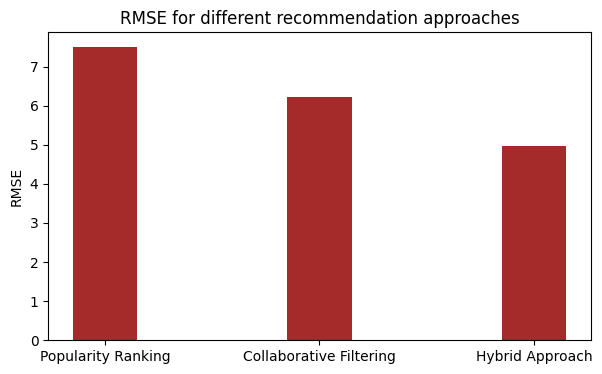

In [70]:
from matplotlib import pyplot as plt
%matplotlib inline

data = {'Popularity Ranking': 7.5, 'Collaborative Filtering': previous_rmse,
        'Hybrid Approach':test_RMSE}

methods = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (7, 4))
 
# creating the bar plot
plt.bar(methods, values, color ='brown',
        width = 0.3)

plt.ylabel("RMSE")
plt.title("RMSE for different recommendation approaches")
plt.show()